In [1]:
# importing
import numpy as np
import pandas as pd
from Crack_Deflection import *
import matplotlib.pyplot as plt
from glob import glob
from numba import jit

import plotly.graph_objects as go
from scipy.spatial import Delaunay
import plotly.figure_factory as ff

from sklearn.cluster import OPTICS, cluster_optics_dbscan
from sklearn.preprocessing import normalize, StandardScaler

In [2]:
# get files for scan
files = glob('./tomo_results_Bovine_Heat_100_Sample2_657_100ms_Load_3pt5N_step10_crack/*')

In [27]:
coord = pd.read_csv('raw_Sample2_130_p10_crack.csv').values

# get gradient
crack_grad_side, crack_grad_top = np.gradient(coord)
# change direction so color map cooresponds to deflection
crack_grad_side, crack_grad_top = -1*crack_grad_side, -1*crack_grad_top

# apply rolling average to the side
crack_grad_side = apply_rolling_average(crack_grad_side)

# apply rolling average to the top
crack_grad_top = crack_grad_top.T
crack_grad_top = apply_rolling_average(crack_grad_top)
crack_grad_top = crack_grad_top.T

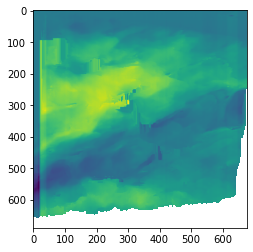

In [28]:
# shift to 0
coord2 = np.where(coord == 0, np.nan, coord) # CHANGED
coord2 -= coord2[-1,:]
coord2 = np.flipud(coord2)
# coord2 -= np.nanmax(coord2)
# coord2 -= coord2[-1,:]

# coord2 = coord
# get left and right limits
# low_dim = np.nanmax(coord2, axis=0)
# low_dim = np.isnan(low_dim)

low_dim = np.isnan(coord2)
low_dim = low_dim == False
low_dim = low_dim.sum(axis=0)

cols = np.where(low_dim != 0)[0]
start = cols[0]
end = cols[-1]

# chop off
xrange = end - start
chop = 0.05
chop_ind = int(xrange*chop)
new_idx = cols[chop_ind:-chop_ind]
coord = -coord2[:,new_idx]
# coord = np.nan_to_num(coord, nan=0)
plt.imshow(coord)
plt.show()

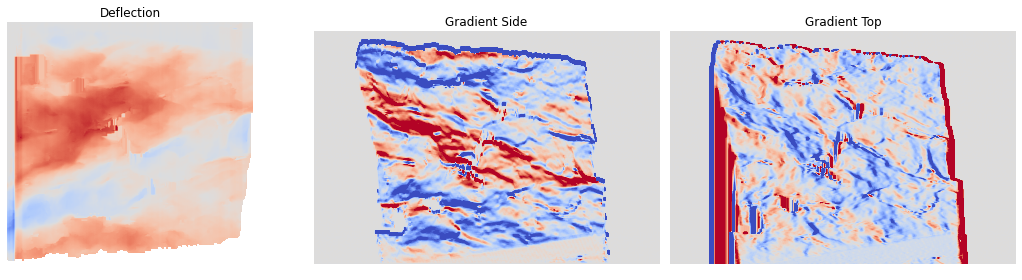

In [29]:
# set colormap
cmap='coolwarm'

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))
v=200
ax[0].imshow(coord, cmap=cmap, vmin=-v, vmax=v)
v=2
ax[1].imshow(crack_grad_side, cmap=cmap, vmin=-v, vmax=v)
v=2
ax[2].imshow(crack_grad_top, cmap=cmap, vmin=-v, vmax=v)

for i, title in enumerate(['Deflection', 'Gradient Side', 'Gradient Top']):
    ax[i].set_title(title)

for a in ax:
    a.axis('off')
fig.tight_layout()
plt.show()

In [30]:
x, y = coord.shape
idx = ~np.isnan(coord)
# idx = coord != 100000 
xx, yy = np.meshgrid(np.arange(y), np.arange(x))
crack_x = xx[idx][::100]
# crack_y = np.flip(yy[idx][::100])
crack_y = yy[idx][::100]
crack_z = coord[idx][::100]

xrange = max(crack_x) - min(crack_x)
yrange = max(crack_y) - min(crack_y)
zrange = max(crack_z) - min(crack_z)
# print(xrange,yrange,zrange)
ratios = np.array([xrange, yrange, zrange])/xrange
aspect = {'x':ratios[0], 'y':ratios[1], 'z':ratios[2]}
# print(aspect)

# uncomment if you want to see scatter
# scatter = [go.Scatter3d(z=crack_z, x=crack_x, y=crack_y, mode='markers', marker=dict(size=3))]
# Fig = go.Figure(data=scatter)
# Fig.show()

In [31]:
points2D = np.vstack([crack_x, crack_y]).T
tri = Delaunay(points2D)
simplices = tri.simplices
triplot = ff.create_trisurf(x=crack_x, y=crack_y, z=crack_z, simplices=simplices, colormap="RdBu", 
                        aspectratio=aspect)
# future work: potentially clean up the edges of the trisurf by taking out simplices
# also make own colorbar

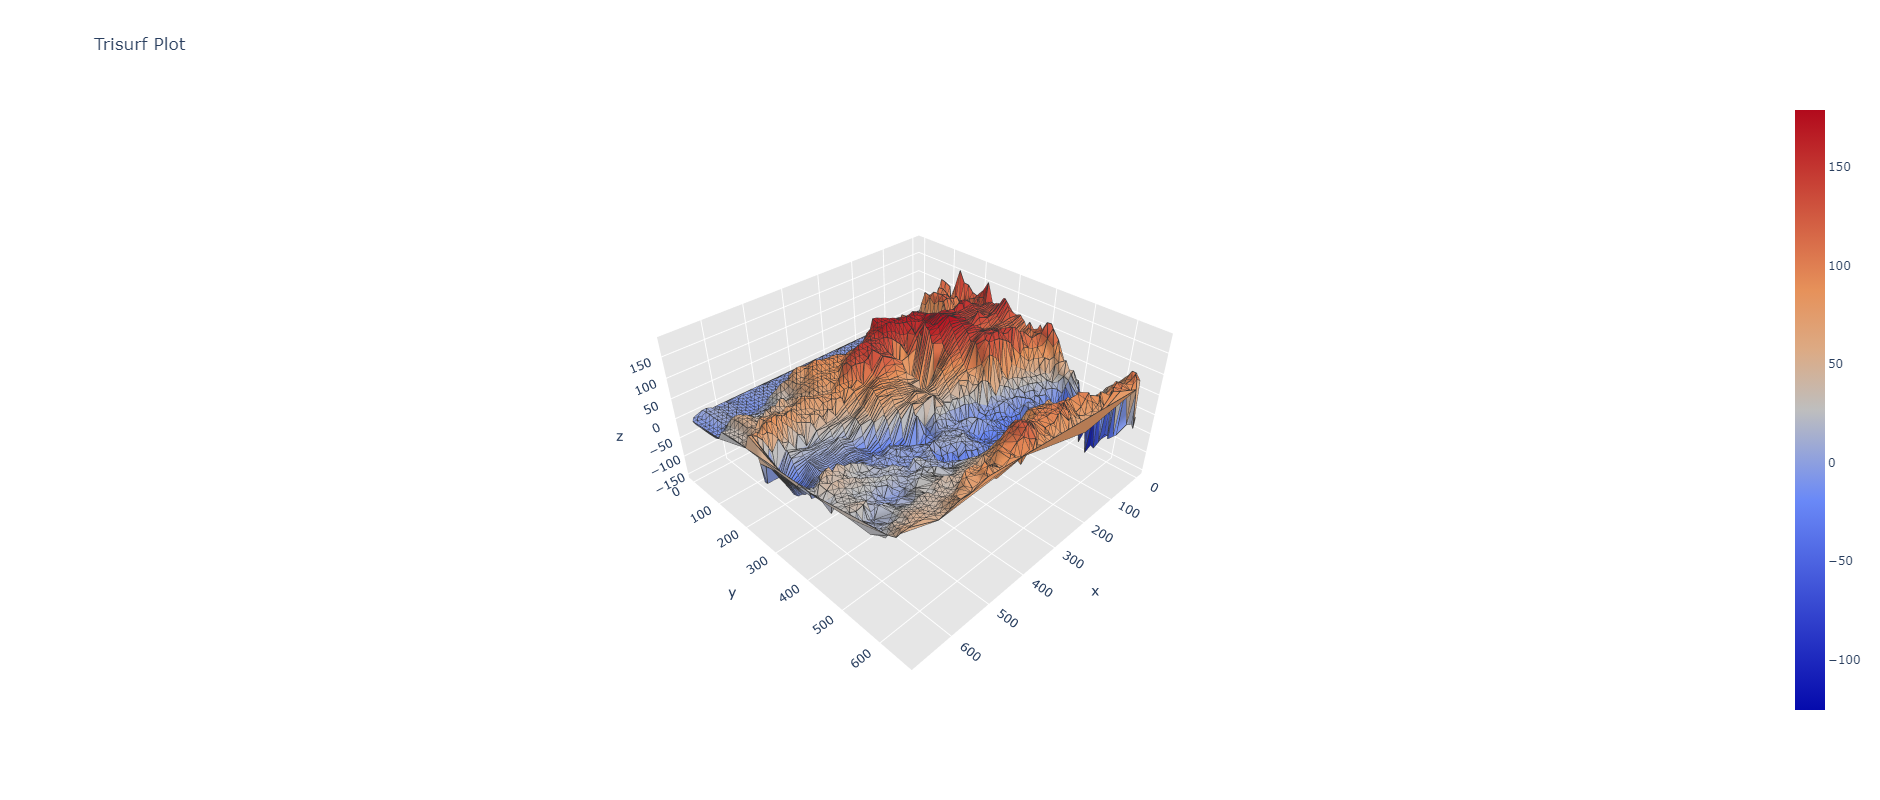

In [32]:
Fig = go.Figure(data=triplot)
Fig.show()

In [33]:
# %%time
# img_idx = 0
# # getting large deflection sections
# # get gradient
# test = np.where(coord == 0, np.nan, coord)
# crack_grad_side = np.gradient(test, axis=0)
# # change direction so color map cooresponds to deflection
# crack_grad_side = -1*crack_grad_side

# # apply rolling average to the side (larger window)
# crack_grad_side2 = apply_rolling_average(crack_grad_side.copy(), window=50)
# c_grad_val = crack_grad_side2[:, img_idx]
# # c_grad_val = np.flip(c_grad_val)
# sign_grad = np.sign(c_grad_val)
# # 2 or -2 when sign flips so take abs
# flip = abs(sign_grad[:-1] - sign_grad[1:])
# deflect_points = np.where(flip != 0)[0]
# deflect_points_new = deflect_points
        
# fig, ax = plt.subplots(figsize=(10, 3))
# for p in deflect_points_new:
#     plt.axvline(x=p, color='k', linestyle='--')
# plt.axhline(y=0, color='k', alpha=0.5)
# # ax.plot(np.flip(crack_grad_side[:,img_idx])*0.4, linestyle='--')
# ax.plot(c_grad_val, 'darkorange', linestyle='--', linewidth=2)
# ax2 = ax.twinx()
# ax2.plot(np.arange(len(coord[:,img_idx])), coord[:,img_idx], 'r', linewidth=2)
# plt.title('Gradient Values')
# ax.set_ylim([-2,4])
# plt.show()

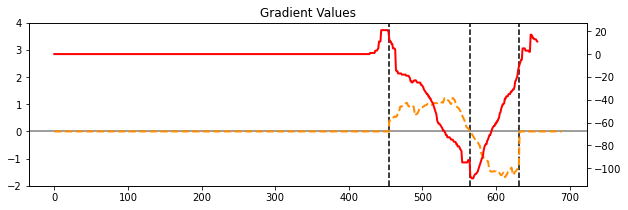

Wall time: 437 ms


In [34]:
%%time
# testing the functions and go faster
img_idx = 0
# getting large deflection sections
# get gradient
test = np.where(coord == 0, np.nan, coord)
crack_grad_side = np.gradient(test, axis=0)
# change direction so color map cooresponds to deflection
crack_grad_side = -1*crack_grad_side
# apply rolling average to the side (larger window)
crack_grad_side2 = apply_rolling_average(crack_grad_side.copy(), window=50)

# put this in the loop
c_grad_val = crack_grad_side2[:, img_idx]
deflect_points = get_sections(c_grad_val, img_idx)

true_deflect_points = deflect_points

fig, ax = plt.subplots(figsize=(10, 3))
for p in deflect_points:
    plt.axvline(x=p, color='k', linestyle='--')
plt.axhline(y=0, color='k', alpha=0.5)
# ax.plot(np.flip(crack_grad_side[:,img_idx])*0.4, linestyle='--')
ax.plot(np.arange(len(coord[:,img_idx])), c_grad_val, 'darkorange', linestyle='--', linewidth=2)
ax2 = ax.twinx()
ax2.plot(np.arange(len(coord[:,img_idx])), coord[:,img_idx], 'r', linewidth=2)
plt.title('Gradient Values')
ax.set_ylim([-2,4])
plt.show()

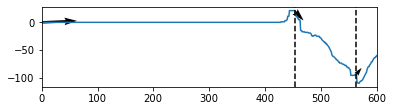

Wall time: 90 ms


In [35]:
%%time
# calculate angle of each section
# z_vals = np.flip(coord[:,img_idx])
z_vals = coord[:,img_idx]

start = 0
angles = np.zeros(len(true_deflect_points))
vectors_o = np.zeros((len(true_deflect_points),2))
vectors_u = np.zeros(len(true_deflect_points))
vectors_v = np.zeros(len(true_deflect_points))
for i, section in enumerate(true_deflect_points):
    end = int(section)
    z_change = z_vals[end] - z_vals[start] # up and down change
    x_change = end - start
    vectors_o[i,:] = start, z_vals[start]
    vectors_u[i] = x_change
    vectors_v[i] = z_change
    angle = np.arctan(z_change/x_change)
    angles[i] = angle*180/np.pi
    start = int(section)
    
fig, ax = plt.subplots()
plt.plot(np.arange(len(z_vals)), z_vals)
for p in true_deflect_points:
    plt.axvline(x=p, color='k', linestyle='--')
# print(angles)
plt.quiver(vectors_o[:,0], vectors_o[:,1],  vectors_u, vectors_v)
plt.xlim([0,600])
# plt.ylim([-200,0])
ax.set_aspect(1)
plt.show()

In [36]:
print(true_deflect_points)
print(vectors_u)
print(vectors_v)

[454 564 631]
[454. 110.  67.]
[  19. -112.   82.]


In [37]:
%%time
step = 10
# getting the angles and the vectors for increments of 10 slices
num_imgs = coord.shape[1]
slices = np.arange(num_imgs)[::step]
all_deflects = []
angle_info = []

test = np.where(coord == 0, np.nan, coord)
crack_grad_side = np.gradient(test, axis=0)
# change direction so color map cooresponds to deflection
crack_grad_side = -1*crack_grad_side
# apply rolling average to the side (larger window)
crack_grad_side2 = apply_rolling_average(crack_grad_side.copy(), window=50)

for num in slices:
    deflect_points = get_sections(crack_grad_side2[:, num], num)
    all_deflects.append(deflect_points)
    angles, vectors_o, vectors_u, vectors_v = get_angles(coord, num, deflect_points)
    angle_info.append((angles, vectors_o, vectors_u, vectors_v))

Wall time: 270 ms


In [38]:
front = np.flip(coord)
# front[:,450]

In [47]:
angle_thresh = 35
mag_thresh = 30

a, x3d, y3d, z3d, u3d, v3d, w3d = [], [], [], [], [], [], []
# for i in range(len(all_deflects)):
# crack_front = np.flip(coord)
for i, info in enumerate(angle_info):
    if len(info[1]) == 0:
        continue
#     print(coord[])
    a.append(info[0])
    y3d.append(info[1][:,0])
    z3d.append(info[1][:,1])
    x3d.append([slices[i]]*len(info[1]))
    v3d.append(info[2])
    w3d.append(info[3])
    u3d.append([0]*len(info[2]))

a3d = np.hstack(a)
x3d = np.hstack(x3d)
y3d = np.hstack(y3d)
z3d = np.hstack(z3d)
u3d = np.hstack(u3d)
v3d = np.hstack(v3d)
w3d = np.hstack(w3d)

idx1 = np.abs(a3d) > angle_thresh
mag = np.linalg.norm(np.array([u3d,v3d,w3d]), axis=0)
idx2 = mag > mag_thresh
idx_final = np.logical_and(idx1, idx2)
a3d = a3d[idx_final]
x3d = x3d[idx_final]
y3d = y3d[idx_final]
z3d = z3d[idx_final]
u3d = u3d[idx_final]
v3d = v3d[idx_final]
w3d = w3d[idx_final]
mag3d = mag[idx_final]

[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19]


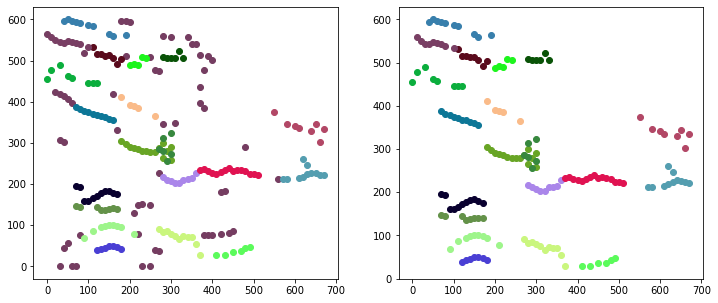

In [48]:
df = pd.DataFrame(dict(angle=a3d, x=x3d, y=y3d))
# print(df.head())
# scaler = StandardScaler()
# df_scaled = scaler.fit_transform(df)
# df_normalized = normalize(df_scaled)
# df_normalized = pd.DataFrame(df_normalized)
# # Renaming the columns
# df_normalized.columns = df.columns
# df_normalized.head()

# Building the OPTICS Clustering model
optics_model = OPTICS(min_samples=4, xi=0.05, min_cluster_size=5)
# Training the model
# optics_model.fit(df_normalized)
optics_model.fit(df)

idxs = optics_model.ordering_
labels = optics_model.labels_[idxs]
# Plotting the OPTICS Clustering
unique = np.unique(labels)
print(unique)
label_idx = []
fig, ax = plt.subplots(1,2, figsize=(12,5))
for label in unique:
    color = tuple(np.random.choice(np.linspace(0,1,256), size=3))
    idx_lab = labels == label
    idx_true = idxs[idx_lab]
    label_idx.append(idx_true)
    ax[0].scatter(x3d[idx_true], y3d[idx_true], color=color)
    if label != -1:
        ax[1].scatter(x3d[idx_true], y3d[idx_true], color=color)
# print(optics_model.ordering_)

In [49]:
d_labels = unique[1:]
i_labels = label_idx[1:]
mean_angles = []
mean_mags = []
for clust in range(len(d_labels)):
    c_idx = i_labels[clust]
    c_angles = a3d[c_idx]
    c_mag = mag3d[c_idx]
    mean_angles.append(np.mean(c_angles))
    mean_mags.append(np.mean(c_mag))
    
# print(mean_angles, mean_mags)
labeled = np.hstack(i_labels)
a3d = a3d[labeled]
x3d = x3d[labeled]
y3d = y3d[labeled]
z3d = z3d[labeled]
u3d = u3d[labeled]
v3d = v3d[labeled]
w3d = w3d[labeled]
mag3d = mag[labeled]

print(mean_angles)
print(mean_mags)

[-50.42618863863026, -55.76636115529793, -59.64488611545912, -51.70466974152447, -44.3697013483878, -44.61625294187833, -48.18877226570791, 44.70642498445027, 38.23057150492135, 45.92424771789583, 46.57276905018307, 47.343559891860785, -44.326542016941914, 39.16273117339251, 74.48676686098202, 56.36198195178184, 53.00712190729424, 55.69638873963015, 58.85214012749353, 48.319409539709476]
[99.70291260406336, 173.99483355578317, 158.99309616132385, 85.6012567237793, 146.6568468091493, 158.53409011811746, 89.81165045530948, 201.00482254708038, 131.88491310970025, 64.79695764259321, 86.06824120227023, 125.30687793121, 57.89295601967363, 72.3910116325409, 79.53870663848264, 133.1480182745128, 160.25185343175983, 133.82621251211822, 119.26053405859946, 56.342588054109605]


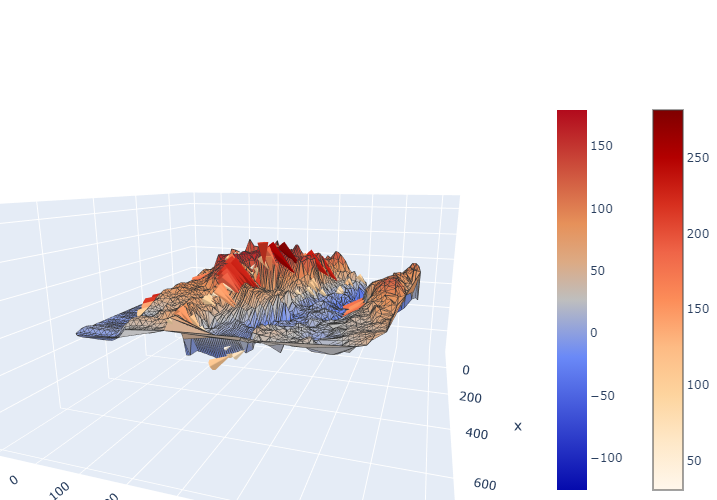

In [50]:
vec_data = go.Cone(x=x3d, y=y3d, z=z3d, u=u3d, v=v3d, w=w3d,
                   anchor='tail', colorscale='OrRd', sizemode='absolute', sizeref=4000,
                  colorbar=dict(x=1.2))
# Fig2 = go.Figure(vec_data)
surf_data = [triplot.data[i] for i in range(len(triplot.data))]
# cone_data = Fig2.data
total_data = surf_data + [vec_data]

Fig3 = go.Figure(total_data)
Fig3.update_layout(scene_camera_eye=dict(x=1.5, y=0.5, z=0.4),
                   width=800, height=500,
                   margin=dict(l=0, r=0, b=0, t=100))
Fig3.show()